In [39]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio

# Turn inFile into a one hot label
def createOneHot(inFile,amountOfClasses):
    outFile = np.zeros((inFile.shape[0],inFile.shape[1], amountOfClasses));
    for i in range(0,inFile.shape[0]):
        for j in range(0,inFile.shape[1]):
            #if inFile[i,j] != 0:
            outFile[i,j,int(inFile[i,j]-1)] = 1;
    return outFile;

# Turn 41 orthomosaics into one array. From 2 separate paths, 1-25 and 1-16
def loadOneOrthomosaic(imagePath1,imagePath2):
    temp = np.asarray( Image.open(imagePath1 + '1.png') )
    inputData = np.zeros( (temp.shape[0],temp.shape[1],inputChannels) ,dtype=np.dtype('uint8'))
    for i in range(1,25):
        temp= np.asarray( Image.open( imagePath1 + 'Band' + str(i) + '.png') );
        inputData[:,:,i] = temp[:,:,0];
    for i in range(1,16):
        temp= np.asarray( Image.open( imagePath2 + 'Band' + str(i) + '.png') );
        inputData[:,:,i+25] = temp[:,:,0];
    return np.expand_dims(inputData,axis=0)

# Turn 41 orthomosaics into one array. From 1 path with Bands 1 to 41
def loadOneOrthomosaic(imagePath):
    temp= np.asarray( Image.open( imagePath + 'Band1.png') );
    inputData = np.zeros(( temp.shape[0], temp.shape[1], inputChannels),dtype=np.dtype('uint8'))
    for i in range(1,41):
        temp= np.asarray( Image.open( imagePath + 'Band' + str(i) + '.png') );
        inputData[:,:,i] = temp[:,:];
    return np.expand_dims( inputData, axis=0)

# Load one label from a .mat
def loadOneLabel(imagePath):
    temp = sio.loadmat(imagePath);
    trainOneHotLabels =  createOneHot( temp['labeledPicture'], amountOfClasses);
    return np.expand_dims( trainOneHotLabels, axis=0)

# Read training data and labels for an array of path tuples, returns (data,labels)
def readSet(paths):
    numberOfImages = len(paths);
    data = np.zeros( (numberOfImages,imageSize[1],imageSize[0],inputChannels), dtype=np.dtype('uint8'));
    labels = np.zeros((numberOfImages,imageSize[1],imageSize[0],amountOfClasses), dtype=np.dtype('uint8'))
    for i in range(0,numberOfImages):
        data[i,:,:,:] = loadOneOrthomosaic(paths[i][0]);
        labels[i,:,:,:] = loadOneLabel(paths[i][1]);
    return data,labels

def oneHotToCategorical(oneHotLabel,threshold):
    temp = np.zeros((oneHotLabel.shape[1],oneHotLabel.shape[2]), dtype=np.dtype('uint8') );
    for i in range(0,oneHotLabel.shape[1]):
        for j in range(0,oneHotLabel.shape[2]):
            #temp[i,j] = np.argmax(oneHotLabel[0,i,j,:]) + 1;
            if np.argmax(oneHotLabel[0,i,j,:])>threshold:
                temp[i,j] = np.argmax(oneHotLabel[0,i,j,:])
    return temp

def predictAndSaveOneImage(inPath,outPath,FCNmodel,threshold):
    testImage = loadOneOrthomosaic(inPath);
    testLabelPredict = FCNmodel.predict(testImage);
    testLabelPredictCat = oneHotToCategorical(testLabelPredict,threshold);
    sio.savemat(outPath, mdict={'testLabelPredict': testLabelPredictCat});

def predictAndSaveSet(pathArray, FCNmodel,threshold):
    numberOfImages = len(pathArray);
    for i in range(0,numberOfImages):
        predictAndSaveOneImage(pathArray[i][0], pathArray[i][1], FCNmodel,threshold)
        print('Saved ' + pathArray[i][1])
        
def plotImage(image):
    plt.imshow(image, cmap='gray')
    plt.show()
    
def getTrainPaths(paths):
    folders = ['FIP','Ximea_Tamron']
    fullPath = []
    for imageType in paths:
        for date in imageType:
            temp = []
            temp.append(basePath+'trainData/'+folders[paths.index(imageType)]+'/'+date+'/')
            temp.append(basePath+'trainLabels/'+folders[paths.index(imageType)]+'_'+date+'.mat') 
            fullPath.append(temp)
    return fullPath
    
def getTestPaths(paths):
    folders = ['FIP','Ximea_Tamron']
    fullPath = []
    for imageType in paths:
        for date in imageType:
            temp = []
            temp.append(basePath+'testData/'+folders[paths.index(imageType)]+'/'+date+'/')
            temp.append(basePath+'testLabelPredict/'+folders[paths.index(imageType)]+'_'+date+'.mat') 
            fullPath.append(temp)
    return fullPath

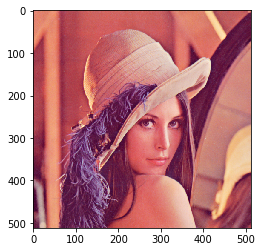

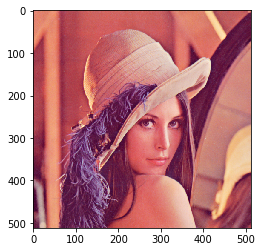

(262144, 3)
uint8


In [32]:
im_frame = Image.open('/Users/jveith/Documents/2018 Semester Project/Matlab/testImages/' + 'Lenna.png')
np_frame = np.array(im_frame.getdata())
plotImage(im_frame)
#plotImage(np.reshape(np_frame,(512,512,3)))
data = np.asarray(im_frame)
plotImage(data)
print(np_frame.shape)
print(data.dtype)

In [10]:
# Data paths
basePath = '/Volumes/mac_jannic_2017/thanujan/Datasets/xFcnClassifier/';

trainSets = [
    #FIP
    [
        '20170622'
    ],
    #Ximea_Tamron
    [
        '20170510',
        '20170622'
    ]
]

validationSets = [
    #FIP
    [
        '20170531'
    ],
    #Ximea_Tamron
    [
    ]
]

testSets = [
    #FIP
    [
        '20170531', 
        '20170622',
        '20170531_cropped',
        '20170622_cropped',
        '20170802'
    ],
    #Ximea_Tamron
    [
        '20170510',
        '20170622',
        '20170510_cropped',
        '20170622_cropped',
        '20170613'
    ]
]
    
trainPaths = getTrainPaths(trainSets)
validationPaths = getTrainPaths(validationSets)
testPaths = getTestPaths(testSets)

# Data parameters
amountOfClasses = 9;
inputChannels = 41;
imageSize = [1600,1600]; # [X,Y]

numberOfEpochs = 20;

In [11]:
from keras.models import *
from keras.layers import Conv2D, MaxPooling2D, Input, Cropping2D, UpSampling2D,concatenate,Dropout

#crop1 = Cropping2D(cropping=((0, 0), (0, 0)))(conv1) # cropping=((Top, Bottom), (Left, Right))

model_inputs = Input(shape=(imageSize[0], imageSize[1], inputChannels))

conv1 = Conv2D(64,3, activation='relu', padding='same')(model_inputs)
conv1 = Conv2D(64,3, activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')(conv1)

conv2 = Conv2D(128,3, activation='relu', padding='same')(pool1)
conv2 = Conv2D(128,3, activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')(conv2)

conv3 = Conv2D(256,3, activation='relu', padding='same')(pool2)
conv3 = Conv2D(256,3, activation='relu', padding='same')(conv3)
drop3 = Dropout(0.5)(conv3)

upconv4 = Conv2D(128,2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop3))
concat4 = concatenate([upconv4,conv2],axis=3)
conv4 = Conv2D(128,3, activation='relu', padding='same')(concat4)
conv4 = Conv2D(128,3, activation='relu', padding='same')(conv4)

upconv5 = Conv2D(64,2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv4))
concat5 = concatenate([upconv5,conv1],axis=3)
conv5 = Conv2D(64,3, activation='relu', padding='same')(concat5)
conv5 = Conv2D(64,3, activation='relu', padding='same')(conv5)

conv6 = Conv2D(amountOfClasses, (1,1), activation='softmax', padding='valid')(conv5)


UNetModel = Model(inputs = model_inputs, outputs = conv6)
UNetModel.compile(optimizer='adagrad',
              loss='categorical_crossentropy',
              metrics=['accuracy']);
print(UNetModel.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1600, 1600, 4 0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 1600, 1600, 6 23680       input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 1600, 1600, 6 36928       conv2d_18[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 800, 800, 64) 0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 

In [5]:
modelBasicNN = Sequential([
    Conv2D(20, (1,1), input_shape=(imageSize[0], imageSize[1], inputChannels), activation='relu'),
    Conv2D(amountOfClasses, (1,1), activation='softmax')
])
modelBasicNN.summary()
modelBasicNN.compile(optimizer='adagrad', loss='categorical_crossentropy', metrics=['accuracy']);

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 1600, 1600, 20)    840       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 1600, 1600, 9)     189       
Total params: 1,029
Trainable params: 1,029
Non-trainable params: 0
_________________________________________________________________


In [35]:
# Load the training data and labels
trainData,trainLabels = readSet(trainPaths)
validationData,validationLabels = readSet(validationPaths)

(3, 1600, 1600, 41)
0


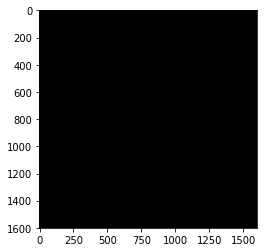

1


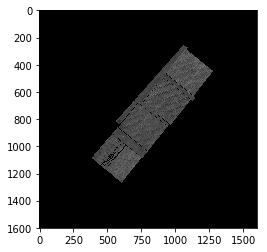

2


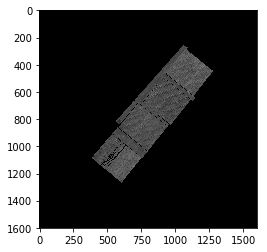

3


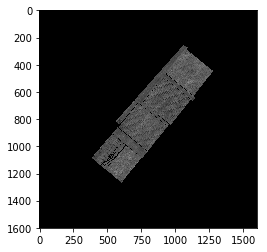

4


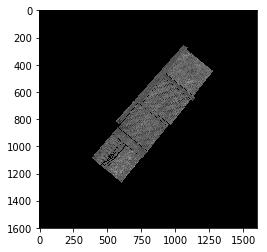

5


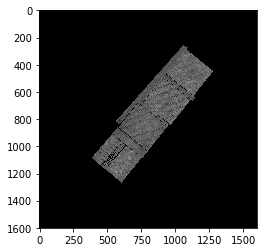

6


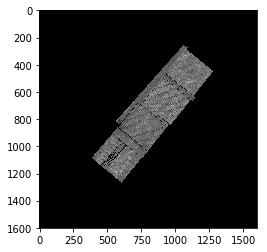

7


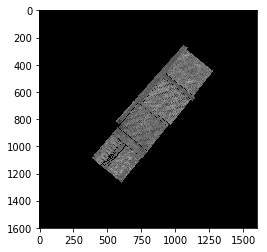

8


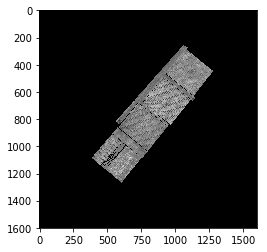

9


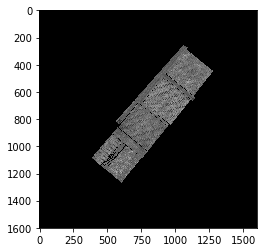

10


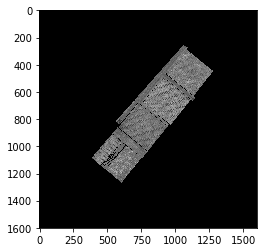

11


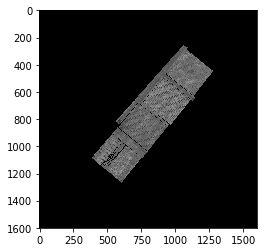

12


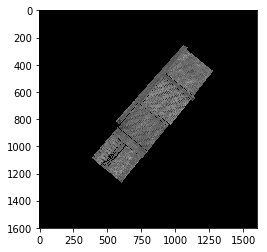

13


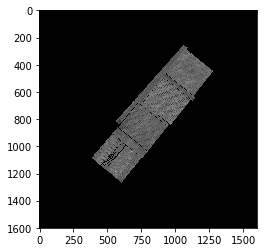

14


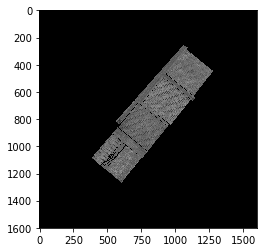

15


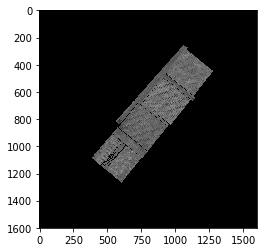

16


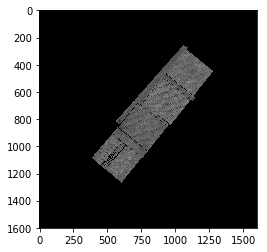

17


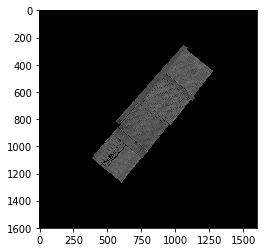

18


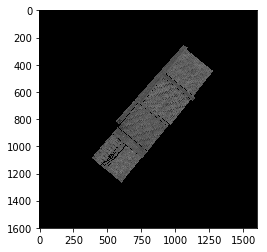

19


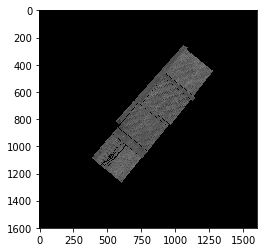

20


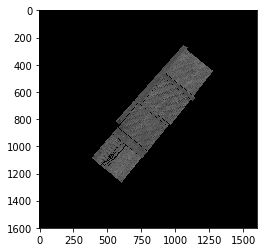

21


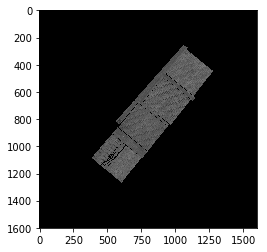

22


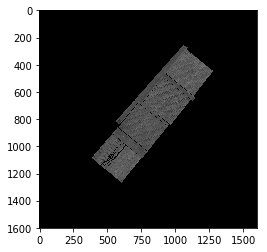

23


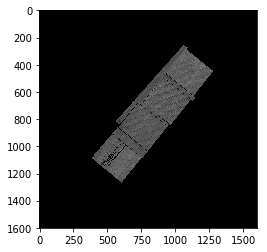

24


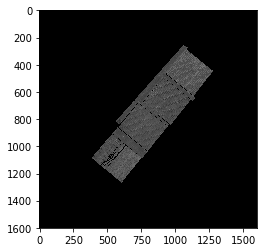

25


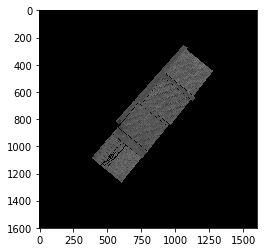

26


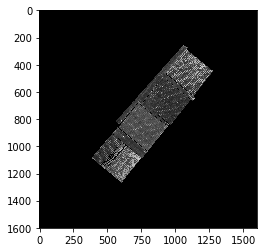

27


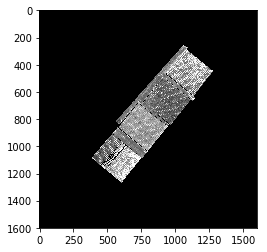

28


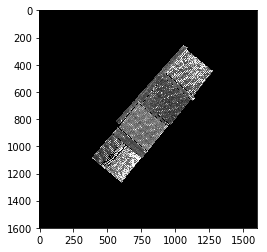

29


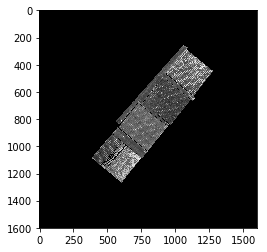

30


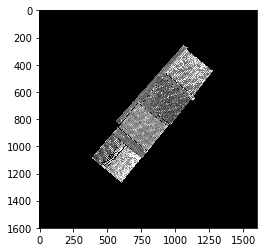

31


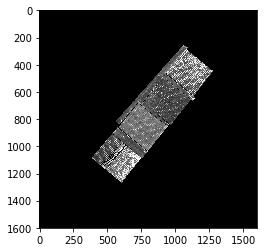

32


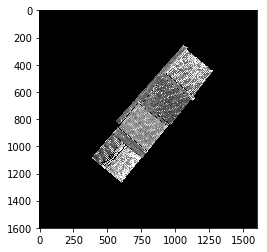

33


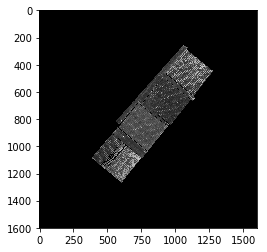

34


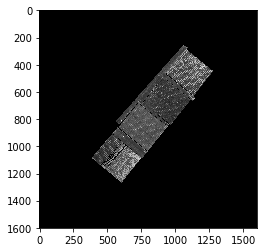

35


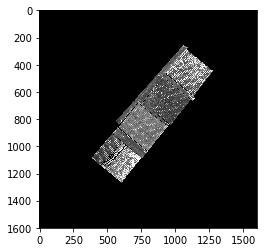

36


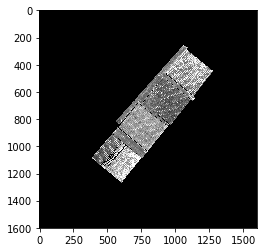

37


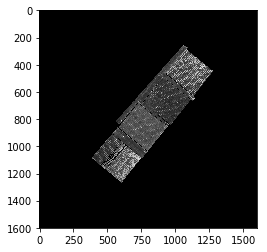

38


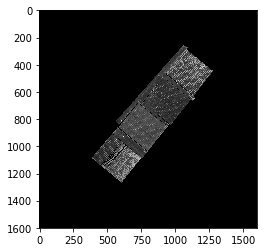

39


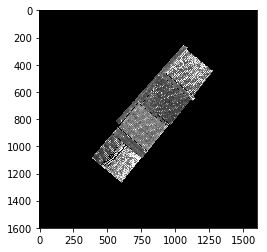

40


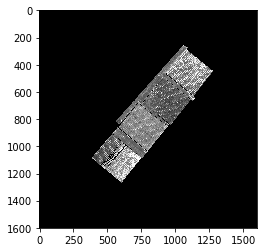

In [43]:
print(trainData.shape)
for i in range(0,41):
    print(i)
    plotImage(trainData[0,:,:,i])

In [8]:
# Train model
modelBasicNN.fit(trainData, trainLabels,validation_data=(validationData,validationLabels), epochs=4);

Train on 3 samples, validate on 1 samples
Epoch 1/4
3/3 [==============================] - 40s 13s/step - loss: 5.4719 - acc: 0.0014 - val_loss: 3.6106 - val_acc: 0.8969
Epoch 2/4
3/3 [==============================] - 37s 12s/step - loss: 5.4393 - acc: 0.7658 - val_loss: 3.5952 - val_acc: 0.8969
Epoch 3/4
3/3 [==============================] - 31s 10s/step - loss: 5.4290 - acc: 0.7658 - val_loss: 3.5890 - val_acc: 0.8969
Epoch 4/4
3/3 [==============================] - 31s 10s/step - loss: 5.4235 - acc: 0.7658 - val_loss: 3.5516 - val_acc: 0.8969


In [112]:
# Save the model
UNetModel.save('networkModels/UNetModel.h5')

In [18]:
# Use trained model to predict
predictAndSaveSet(testPaths, modelBasicNN,.4);

Saved /Volumes/mac_jannic_2017/thanujan/Datasets/xFcnClassifier/testLabelPredict/FIP_20170531.mat
Saved /Volumes/mac_jannic_2017/thanujan/Datasets/xFcnClassifier/testLabelPredict/FIP_20170622.mat
Saved /Volumes/mac_jannic_2017/thanujan/Datasets/xFcnClassifier/testLabelPredict/FIP_20170531_cropped.mat
Saved /Volumes/mac_jannic_2017/thanujan/Datasets/xFcnClassifier/testLabelPredict/FIP_20170622_cropped.mat
Saved /Volumes/mac_jannic_2017/thanujan/Datasets/xFcnClassifier/testLabelPredict/FIP_20170802.mat
Saved /Volumes/mac_jannic_2017/thanujan/Datasets/xFcnClassifier/testLabelPredict/Ximea_Tamron_20170510.mat
Saved /Volumes/mac_jannic_2017/thanujan/Datasets/xFcnClassifier/testLabelPredict/Ximea_Tamron_20170622.mat
Saved /Volumes/mac_jannic_2017/thanujan/Datasets/xFcnClassifier/testLabelPredict/Ximea_Tamron_20170510_cropped.mat
Saved /Volumes/mac_jannic_2017/thanujan/Datasets/xFcnClassifier/testLabelPredict/Ximea_Tamron_20170622_cropped.mat
Saved /Volumes/mac_jannic_2017/thanujan/Datasets/x

In [9]:
testImage = loadOneOrthomosaic('/Volumes/mac_jannic_2017/thanujan/Datasets/xFcnClassifier/testData/FIP/20170531/');
testLabelPredict = modelBasicNN.predict(testImage);
testLabelPredictCat = oneHotToCategorical(testLabelPredict);

In [12]:
testLabelPredict[0,400,800,:]

array([0.1104096 , 0.1104096 , 0.1104096 , 0.1104096 , 0.1104096 ,
       0.1104096 , 0.1104096 , 0.1104096 , 0.11672311], dtype=float32)